# 人臉辨識 - 人臉特徵擷取(FaceNet) & 訓練人臉分類器

人臉辨識大致可分成四個主要的步驟:
1. 人臉偵測
2. 人臉轉換、對齊與裁剪
3. 人臉特徵擷取
4. 人臉特徵比對

在[[7.2-face-detect-align-and-crop](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/7.2-face-detect-align-and-crop.ipynb)]己經詳細介紹如何進行"人臉偵測"、"對齊" & "裁剪"了, 因此這篇文章會著重在:
3. 人臉特徴擷取 (使用__FaceNet__的模型與演算法)
4. 人臉特徵比對 (使用__LinearSVC__的分類演算法)

對應到以下的圖例的話, 就是使用深度學習所學習到的一個網絡來將人臉的圖像轉換成一個"人臉特徴向量(representation)", 然後利用這個"人臉特徴向量(representation)"來進行人臉的辨識(recognition)、人臉的比對(verification)或是人臉的聚類(cluster)。

![openface](https://raw.githubusercontent.com/cmusatyalab/openface/master/images/summary.jpg)

## 理論

GOOGLE於2015年發表一個網絡結構名為FaceNet。它可以直接將人臉圖像映射至歐式空間，透過比對兩個人臉圖像映射(embedding)的歐幾里德距離能直接反應出人臉間的相似度。一旦生成該人臉圖像映射表示(embedding representation)，識別，驗證，聚類等任務都可以用它來輕鬆完成。 FaceNet在LFW上達到了99.63％的準確率，在Youtube Faces DB達到95.12％。
和大部份其它的演算法（先輸出高維度特徵向量，然後用PCA等降維，再用分類器分類）不同之處，FaceNet直接使用基於三元組的LMNN（最大邊界近鄰分類）的損失函數訓練神經網絡，網絡直接輸出為128維度的向量空間。

![face-net](https://raw.githubusercontent.com/stdcoutzyx/Blogs/master/papers/imgs/n8-1.png)

詳細: [FaceNet: A unified embedding for face recognition and clustering](https://arxiv.org/abs/1503.03832)

## face-recognition 專案說明

[face-recognition](https://github.com/erhwenkuo/face-recognition)包含了使用MTCNN與FaceNet來進行人臉辨識。

### 安裝

```bash
git clone https://github.com/erhwenkuo/face-recognition.git
cd face-recognition
...
```

### 資料集說明

LFW資料集是一個常見的人臉資料集，歷史非常悠久。LFW資料集中收錄了5749位公眾人物的人臉影像，總共有超過一萬三千多張影像檔案。但大部份公眾人物的影像都只有一張，只有1680位有超過一張照片，而極少數有超過10張照片。

資料集的網站: http://vis-www.cs.umass.edu/lfw

### 專案的檔案路徑佈局

1. 使用Git從[erhwenkuo/face-recognition]https://github.com/erhwenkuo/face-recognition.git)下載整個專案源碼
2. 在`face-recognition`的目錄裡產生二個子目錄`data`與`model`
3. 從[Labeled Faces in the Wild資料集官網]點撃[All images as gzipped tar file](http://vis-www.cs.umass.edu/lfw/lfw.tgz)來下 載`lfw.tgz`。
4. 解壓縮`lfw.tgz`到`face-recognition/data/`的目錄下
5. 執行`01-face-detect-align-and-crop.ipynb`來進行臉部偵測、對齊 & 裁剪
6. 下載Facenet模型檔[20170511-185253.zip(168M)](https://drive.google.com/file/d/0B5MzpY9kBtDVZ2RpVDYwWmxoSUk)並解壓縮到"model/facenet"的目錄下。
7. 在"model"的目錄下產生一個子目錄"svm"來存放"人臉分類器"的模型。

最後你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
face-recognition/
├── 01-face-detect-align-and-crop.ipynb
├── 02-face-embedding-and-recognition-classifier.ipynb
├── detect_face.py
├── facenet.py
├── model/
│   ├── svm/                                <--- 人臉分類器(svm)的模型
│   ├── mtcnn/
│   │   ├── det1.npy
│   │   ├── det2.npy
│   │   └── det3.npy
│   └── facenet/                            <--- Facenet的模型
│       └── 20170512-110547/
│          ├── 20170512-110547.pb
│          ├── model-20170512-110547.ckpt-250000.data-00000-of-00001
│          ├── model-20170512-110547.ckpt-250000.index
│          └── model-20170512-110547.meta
└── data/
    ├── lfw/
    │   ├── Aaron_Eckhart/     
    │   │   └── Aaron_Eckhart_0001.jpg
    │   ├── ...
    │   └── Zydrunas_Ilgauskas/
    │       └── Zydrunas_Ilgauskas_0001.jpg
    └── lfw_crops/                          <--- 經過偵測、對齊 & 裁剪後的人臉圖像
        ├── Aaron_Eckhart/     
        │   └── Aaron_Eckhart_0001.png
        ├── ...
        └── Zydrunas_Ilgauskas/
            └── Zydrunas_Ilgauskas_0001.png    
```

### STEP 1. 載入相關函式庫

In [1]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import sys
import os
from tqdm import tqdm
import math

# 多維向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2

# 深度學習相關函式庫
import tensorflow as tf

# 專案相關函式庫
import facenet
import detect_face

# 模型序列化函式庫
import pickle

# 人臉分類器函式庫
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

### STEP 2. 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# FaceNet的模型
FACENET_MODEL_PATH = os.path.join(MODEL_PATH, "facenet","20170512-110547","20170512-110547.pb")

# Classifier的模型
SVM_MODEL_PATH = os.path.join(MODEL_PATH, "svm", "lfw_svm_classifier.pkl")

# 訓練/驗證用的圖像資料目錄
IMG_IN_PATH = os.path.join(DATA_PATH, "lfw")

# 訓練/驗證用的圖像資料目錄
IMG_OUT_PATH = os.path.join(DATA_PATH, "lfw_crops")

###  STEP 3. 轉換每張人臉的圖像成為Facenet的人臉特徵向量(128 bytes)表示

函式: `facenet.get_dataset`
```
參數:
    paths (string): 圖像資料集的檔案路徑
    has_class_directories (bool): 是否使用子目錄名作為人臉的identity (預設為True)
    path_expanduser (bool): 是否把path中包含的"~"和"~user"轉換成在作業系統下的用戶根目錄 (預設為False)
回傳:
    dataset (list[ImageClass])： 人臉類別(ImageClass)的列表與圖像路徑
```

In [3]:
datadir = IMG_OUT_PATH # 經過偵測、對齊 & 裁剪後的人臉圖像目錄
# 取得人臉類別(ImageClass)的列表與圖像路徑
dataset = facenet.get_dataset(datadir)        
# 原始: 取得每個人臉圖像的路徑與標籤
paths, labels, labels_dict = facenet.get_image_paths_and_labels(dataset)        
print('Origin: Number of classes: %d' % len(labels_dict))
print('Origin: Number of images: %d' % len(paths))

# 由於lfw的人臉圖像集中有很多的人臉類別只有1張的圖像, 對於訓練來說樣本太少
# 因此我們只挑選圖像樣本張數大於5張的人臉類別

# 過濾: 取得每個人臉圖像的路徑與標籤 (>=5)
paths, labels, labels_dict = facenet.get_image_paths_and_labels(dataset, enable_filter=True, filter_size=5)        
print('Filtered: Number of classes: %d' % len(labels_dict))
print('Filtered: Number of images: %d' % len(paths))

Origin: Number of classes: 5752
Origin: Number of images: 13245
Filtered: Number of classes: 424
Filtered: Number of images: 5997


In [4]:
# 使用Tensorflow的Facenet模型
with tf.Graph().as_default():
    with tf.Session() as sess:
        datadir = IMG_OUT_PATH # 經過偵測、對齊 & 裁剪後的人臉圖像目錄
        # 取得人臉類別(ImageClass)的列表與圖像路徑
        dataset = facenet.get_dataset(datadir)        
        # 原始: 取得每個人臉圖像的路徑與標籤
        paths, labels, labels_dict = facenet.get_image_paths_and_labels(dataset)        
        print('Origin: Number of classes: %d' % len(labels_dict))
        print('Origin: Number of images: %d' % len(paths))
        
        # 由於lfw的人臉圖像集中有很多的人臉類別只有1張的圖像, 對於訓練來說樣本太少
        # 因此我們只挑選圖像樣本張數大於5張的人臉類別
        
        # 過濾: 取得每個人臉圖像的路徑與標籤 (>=5)
        paths, labels, labels_dict = facenet.get_image_paths_and_labels(dataset, enable_filter=True, filter_size=5)        
        print('Filtered: Number of classes: %d' % len(labels_dict))
        print('Filtered: Number of images: %d' % len(paths))
            
        # 載入Facenet模型
        print('Loading feature extraction model')
        modeldir =  FACENET_MODEL_PATH #'/..Path to Pre-trained model../20170512-110547/20170512-110547.pb'
        facenet.load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]
        # 打印"人臉特徵向量"的向量大小
        print("Face embedding size: ", embedding_size)
        
        # 計算人臉特徵向量 (128 bytes)
        print('Calculating features for images')
        batch_size = 1000 # 批次量
        image_size = 160  # 要做為Facenet的圖像輸入的大小
        
        nrof_images = len(paths) # 總共要處理的人臉圖像
        # 計算總共要跑的批次數
        nrof_batches_per_epoch = int(math.ceil(1.0 * nrof_images / batch_size))
        # 構建一個變數來保存"人臉特徵向量"
        emb_array = np.zeros((nrof_images, embedding_size)) # <-- Face Embedding
        
        for i in tqdm(range(nrof_batches_per_epoch)):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, nrof_images)
            paths_batch = paths[start_index:end_index]
            images = facenet.load_data(paths_batch, False, False, image_size)
            feed_dict = {images_placeholder: images, phase_train_placeholder: False}
            emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)

Origin: Number of classes: 5752
Origin: Number of images: 13245
Filtered: Number of classes: 424
Filtered: Number of images: 5997
Loading feature extraction model
Model filename: /home/share/John/face-recognition/model/facenet/20170512-110547/20170512-110547.pb


  0%|          | 0/6 [00:00<?, ?it/s]

Face embedding size:  128
Calculating features for images


100%|██████████| 6/6 [00:25<00:00,  4.30s/it]


In [5]:
paths_batch

['/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0016.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0001.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0026.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0010.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0025.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0009.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0015.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0018.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0002.png',
 '/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0013.png',
 '/home/share/John/face-recognition/data

In [6]:
test = facenet.load_data(['/home/share/John/face-recognition/data/lfw_crops/Rudolph_Giuliani/Rudolph_Giuliani_0016.png'], False, False, image_size)

經過過濾之後, 我們從lfw的人臉資料庫中選出**423**個人臉的類別(每個類別都至少有**5**張的圖像以上)。

### STEP 4. 保存人臉Facenet處理過的人臉embedding的資料

為了能夠重覆地使用己經轉換過的人臉embedding的資料(一般來說可以把這樣的資料保存在資料庫中), 我們把這個資料透過pickle把相關資料保存到檔案中。

In [5]:
# 序列化相關可重覆使用的資料

# 保存"檔案名稱"
names = [os.path.splitext(os.path.split(path)[1])[0] for path in paths]
img_file_name = open(os.path.join(DATA_PATH,'lfw_img_file_name.pkl'), 'wb')
pickle.dump(names, img_file_name)
img_file_name.close()

# 保存"人臉照片路徑"
img_path = open(os.path.join(DATA_PATH,'lfw_img_path.pkl'), 'wb')
pickle.dump(paths, img_path)
img_path.close()

# 保存"人臉embedding"的資料
emb_features_file = open(os.path.join(DATA_PATH,'lfw_emb_features.pkl'), 'wb')
pickle.dump(emb_array, emb_features_file)
emb_features_file.close()

# 保存"人臉embedding"所對應的標籤(label)的資料
emb_lables_file = open(os.path.join(DATA_PATH,'lfw_emb_labels.pkl'), 'wb')
pickle.dump(labels, emb_lables_file)
emb_lables_file.close()

# 保存"標籤(label)對應到人臉名稱的字典的資料
emb_lables_dict_file = open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'wb')
pickle.dump(labels_dict, emb_lables_dict_file)
emb_lables_dict_file.close()

### STEP 5. 載入人臉Facenet處理過的相關的人臉embedding資料

In [6]:
# 反序列化相關可重覆使用的資料

# "人臉embedding"的資料
with open(os.path.join(DATA_PATH,'lfw_emb_features.pkl'), 'rb') as emb_features_file:
    emb_features =pickle.load(emb_features_file)

# "人臉embedding"所對應的標籤(label)的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels.pkl'), 'rb') as emb_lables_file:
    emb_labels =pickle.load(emb_lables_file)

# "標籤(label)對應到人臉名稱的字典的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'rb') as emb_lables_dict_file:
    emb_labels_dict =pickle.load(emb_lables_dict_file)

In [7]:
print("人臉embedding featues: {}, shape: {}, type: {}".format(len(emb_features), emb_features.shape, type(emb_features)))
print("人臉embedding labels: {}, type: {}".format(len(emb_labels), type(emb_labels)))
print("人臉embedding labels dict: {}, type: {}", len(emb_labels_dict), type(emb_labels_dict))

人臉embedding featues: 5997, shape: (5997, 128), type: <class 'numpy.ndarray'>
人臉embedding labels: 5997, type: <class 'list'>
人臉embedding labels dict: {}, type: {} 424 <class 'dict'>


### STEP 6. 準備訓練資料集與驗證資料集
由於lfw的人臉資料集裡, 每一個人的人臉圖像並不多。因此我們將對每一個人的人臉圖像抽取一張來作為驗證資料集, 其餘的圖像則做為訓練資料集。

In [8]:
# 準備相關變數
X_train = []; y_train = []
X_test = []; y_test = []

# 保存己經有處理過的人臉label
processed = set()

# 分割訓練資料集與驗證資料集
for (emb_feature, emb_label) in zip(emb_features, emb_labels):
    if emb_label in processed:
        X_train.append(emb_feature)
        y_train.append(emb_label)
    else:
        X_test.append(emb_feature)
        y_test.append(emb_label)
        processed.add(emb_label)

# 結果
print('X_train: {}, y_train: {}'.format(len(X_train), len(y_train)))
print('X_test: {}, y_test: {}'.format(len(X_test), len(y_test)))


X_train: 5573, y_train: 5573
X_test: 424, y_test: 424


### STEP 7. 訓練人臉分類器(SVM Classifier)

使用scikit-learn的SVM分類器來進行訓練。

在 "https://github.com/davidsandberg/facenet/issues/134" 的討論裡有詳算的參數說明與結果的分析!

![detect-result](https://cloud.githubusercontent.com/assets/2711650/22487753/ec7e0ee8-e80e-11e6-8d69-9aebec5064d0.png)

### 使用linearSvc來訓練

In [9]:
# 訓練分類器
print('Training classifier')
linearsvc_classifier = LinearSVC(C=1, multi_class='ovr')

# 進行訓練
linearsvc_classifier.fit(X_train, y_train)

# 使用驗證資料集來檢查準確率
score = linearsvc_classifier.score(X_test, y_test)

# 打印分類器的準確率
print("Validation result: ", score)

Training classifier
Validation result:  0.990566037736


In [10]:
# 序列化"人臉辨識模型"到檔案
classifier_filename = SVM_MODEL_PATH

# 產生一個人臉的人名列表，以便辨識後來使用
class_names = [cls.name.replace('_', ' ') for cls in dataset]

# 保存人臉分類器到檔案系統
with open(classifier_filename, 'wb') as outfile:
    pickle.dump((linearsvc_classifier, class_names), outfile)
    
print('Saved classifier model to file "%s"' % classifier_filename)

Saved classifier model to file "/home/share/John/face-recognition/model/svm/lfw_svm_classifier.pkl"


在簡單地使用Support Vector Machine (SVM)的模型, 在lfw的人臉資料庫裡頭我們選出來的__423__個不同人臉經過Facenet的人臉特徴抽取之後做多類別的分類學習。由以上的簡單驗證來看可以達到__97.87%__的正確人臉辨識率。

---

## STEP 8. 預測
### 讀取特徵、labels

In [12]:
# 反序列化相關可重覆使用的資料

# "檔案名稱"
with open(os.path.join(DATA_PATH, 'lfw_img_file_name.pkl'), 'rb') as img_file_name:
    img_names = pickle.load(img_file_name)

# "人臉照片路徑"
with open(os.path.join(DATA_PATH, 'lfw_img_path.pkl'), 'rb') as img_path_file:
    img_paths = pickle.load(img_path_file)

# "人臉embedding"的資料
with open(os.path.join(DATA_PATH,'lfw_emb_features.pkl'), 'rb') as emb_features_file:
    emb_features = pickle.load(emb_features_file)

# "人臉embedding"所對應的標籤(label)的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels.pkl'), 'rb') as emb_lables_file:
    emb_labels = pickle.load(emb_lables_file)

# "標籤(label)對應到人臉名稱的字典的資料
with open(os.path.join(DATA_PATH,'lfw_emb_labels_dict.pkl'), 'rb') as emb_lables_dict_file:
    emb_labels_dict = pickle.load(emb_lables_dict_file)

In [13]:
print("照片名稱: {}, type: {}".format(len(img_names), type(img_names)))
print("人臉照片: {}, type: {}".format(len(img_paths), type(img_paths)))
print("人臉embedding featues: {}, shape: {}, type: {}".format(len(emb_features), emb_features.shape, type(emb_features)))
print("人臉embedding labels: {}, type: {}".format(len(emb_labels), type(emb_labels)))
print("人臉embedding labels dict: {}, type: {}".format(len(emb_labels_dict), type(emb_labels_dict)))

照片名稱: 5997, type: <class 'list'>
人臉照片: 5997, type: <class 'list'>
人臉embedding featues: 5997, shape: (5997, 128), type: <class 'numpy.ndarray'>
人臉embedding labels: 5997, type: <class 'list'>
人臉embedding labels dict: 424, type: <class 'dict'>


### 載入模型、預測

In [16]:
import matplotlib.pyplot as plt
import random

Input image : Jean_Chretien
Predict : Jean_Chretien


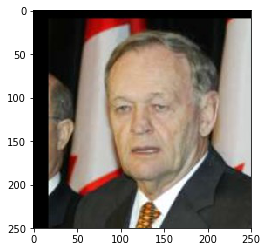

In [17]:
classifier_filename = SVM_MODEL_PATH

pred_img = random.randrange(0,len(emb_labels))
name = emb_labels_dict[emb_labels[pred_img]]
with open(classifier_filename, 'rb') as f:
    cf = pickle.load(f)
    predict = cf[0].predict(emb_features[pred_img,None])
    print('Input image :', name)
    print('Predict :', emb_labels_dict[predict[0]])
img = plt.imread(os.path.join(IMG_IN_PATH, emb_labels_dict[emb_labels[pred_img]], img_names[pred_img]+'.jpg'))
plt.imshow(img)

In [33]:
lValue = 'Woody_Lin'
lkey = [key for key, value in emb_labels_dict.items() if value == lValue]

In [38]:
pred_img = emb_labels.index(lkey[0])
name = emb_labels_dict[emb_labels[pred_img]]
print(name)

Woody_Lin


Input image : Woody_Lin
Predict : Woody_Lin


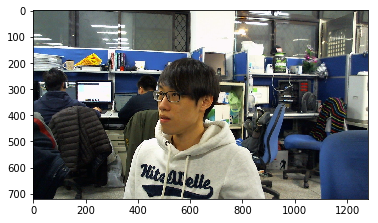

In [39]:
name = emb_labels_dict[emb_labels[pred_img]]
with open(classifier_filename, 'rb') as f:
    cf = pickle.load(f)
    predict = cf[0].predict(emb_features[pred_img,None])
    print('Input image :', name)
    print('Predict :', emb_labels_dict[predict[0]])
img = plt.imread(os.path.join(IMG_IN_PATH, emb_labels_dict[emb_labels[pred_img]], img_names[pred_img]+'.jpg'))
plt.imshow(img)